# Getting prediction and datas

In [1]:
import os
import numpy as np
from geopy import distance
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss, MSELoss
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from datetime import datetime
from stack_image import StackedImageDataset, SingleImageDataset
from model import StreetViewNet
from args import args

data_path = 'C:/Users/ASUS/Downloads/Machine-Learning-Final-Project-kaggle50k/Machine-Learning-Final-Project-kaggle50k/processed/processed'


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_32_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_32_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
# available_gpus = [i for i in range(torch.cuda.device_count())]
# least_used_gpu = min(available_gpus, key=lambda i: torch.cuda.memory_reserved(i))
# torch.cuda.set_device(least_used_gpu)
# device = least_used_gpu
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}")
start_time = datetime.now().strftime("%m-%d-%H-%M")

Using device cpu


In [3]:
writer = SummaryWriter()

transform = transforms.Compose([
    # transforms.RandomCrop(80),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

standard_transform = transforms.Compose([
    # transforms.RandomCrop(80),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [4]:
generator = torch.Generator().manual_seed(args.random_seed)
train_dataset = SingleImageDataset(data_path, transform=transform, is_train=True)
val_dataset = SingleImageDataset(data_path, transform=standard_transform, is_train=False)
num_class = len(train_dataset.country_list)

num_class = len(train_dataset.country_list)

model_path = 'C:/Users/ASUS/Downloads/Machine-Learning-Final-Project-kaggle50k/Machine-Learning-Final-Project-kaggle50k/code/model-19-1121.pth'
model = StreetViewNet(num_class=num_class)

checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])

# if os.path.exists(model_path):
#     model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
#     # model = torch.load(model_path, map_location=torch.device('cpu'))
#     print(f"Loaded existing model from {model_path}")

C:\Users\ASUS\AppData\Local\Temp\ipykernel_40100\3675723628.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=torch.devic

<All keys matched successfully>

In [5]:
len(train_dataset.country_list)

10

In [6]:
print(len(train_dataset))
print(len(val_dataset))

40006
10002


In [7]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_dataset.label_df['country'].values),
    y=train_dataset.label_df['country'].values
)
class_weights = torch.FloatTensor(class_weights).to(device)

class_lossfn = CrossEntropyLoss(label_smoothing=args.label_smoothing, weight=class_weights)

In [8]:
print(type(model))

<class 'model.StreetViewNet'>


In [9]:
val_loss = 0
val_predict_outputs = []
val_labels = []

for i, (images, labels) in enumerate(DataLoader(val_dataset)):
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    val_predict_outputs.append(outputs.detach().numpy())
    val_labels.append(labels.detach().numpy())
    val_loss += class_lossfn(outputs, labels).item()
    print(f'\r number: [{i}/{len(val_dataset)}]', end='', flush=True)

 number: [10001/10002]

In [10]:
train_loss = 0
train_predict_outputs = []
train_labels = []

for i, (images, labels) in enumerate(DataLoader(train_dataset)):
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    train_predict_outputs.append(outputs.detach().numpy())
    train_labels.append(labels.detach().numpy())
    train_loss += class_lossfn(outputs, labels).item()
    print(f'\r number: [{i}/{len(train_dataset)}]', end='', flush=True)

 number: [40005/40006]

In [11]:
train_loss / len(train_dataset)

0.8890836548326684

In [12]:
val_loss / len(val_dataset)

1.1414031766517427

In [13]:
print(train_labels)

[array([1], dtype=int64), array([9], dtype=int64), array([0], dtype=int64), array([7], dtype=int64), array([7], dtype=int64), array([3], dtype=int64), array([0], dtype=int64), array([3], dtype=int64), array([3], dtype=int64), array([7], dtype=int64), array([2], dtype=int64), array([9], dtype=int64), array([7], dtype=int64), array([1], dtype=int64), array([4], dtype=int64), array([8], dtype=int64), array([7], dtype=int64), array([7], dtype=int64), array([8], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([2], dtype=int64), array([8], dtype=int64), array([3], dtype=int64), array([7], dtype=int64), array([2], dtype=int64), array([3], dtype=int64), array([4], dtype=int64), array([1], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([6], dtype=int64), array([7], dtype=int64), array([0], dtype=int64), array([8], dtype=int64), array([8], dtype=int64), array([3], dtype=int64), array([1], dtype=int64), array([6], dtype=int64), array([4], dtype=int64),

In [14]:
print(val_labels)

[array([0], dtype=int64), array([3], dtype=int64), array([9], dtype=int64), array([5], dtype=int64), array([7], dtype=int64), array([9], dtype=int64), array([6], dtype=int64), array([4], dtype=int64), array([1], dtype=int64), array([3], dtype=int64), array([2], dtype=int64), array([5], dtype=int64), array([9], dtype=int64), array([2], dtype=int64), array([2], dtype=int64), array([3], dtype=int64), array([6], dtype=int64), array([0], dtype=int64), array([4], dtype=int64), array([3], dtype=int64), array([8], dtype=int64), array([6], dtype=int64), array([4], dtype=int64), array([9], dtype=int64), array([4], dtype=int64), array([1], dtype=int64), array([2], dtype=int64), array([4], dtype=int64), array([5], dtype=int64), array([5], dtype=int64), array([8], dtype=int64), array([8], dtype=int64), array([6], dtype=int64), array([9], dtype=int64), array([0], dtype=int64), array([7], dtype=int64), array([2], dtype=int64), array([0], dtype=int64), array([2], dtype=int64), array([5], dtype=int64),

# Make confusion matrix

In [15]:
import pandas as pd

df_val_labels = pd.DataFrame(np.vstack(val_labels))
df_val_predict_outputs = pd.DataFrame(np.vstack(val_predict_outputs))

df_train_labels = pd.DataFrame(np.vstack(train_labels))
df_train_predict_outputs = pd.DataFrame(np.vstack(train_predict_outputs))

In [16]:
# 國家名稱列表
country_list = ['United States', 'Australia', 'Thailand', 'Kenya',
                             'South Africa', 'India', 'Canada', 'Finland', 
                             'France', 'New Zealand']

# 使用 enumerate 創建從索引到國家名稱的字典
index_to_country = {index: country for index, country in enumerate(country_list)}

# 輸出字典
print(index_to_country)

{0: 'United States', 1: 'Australia', 2: 'Thailand', 3: 'Kenya', 4: 'South Africa', 5: 'India', 6: 'Canada', 7: 'Finland', 8: 'France', 9: 'New Zealand'}


In [17]:
val_predicted_class_indices = df_val_predict_outputs.idxmax(axis=1)
train_predicted_class_indices = df_train_predict_outputs.idxmax(axis=1)

val_predicted_countries = [index_to_country[idx] for idx in val_predicted_class_indices]
train_predicted_countries = [index_to_country[idx] for idx in train_predicted_class_indices]

val_predicted_countries = pd.DataFrame(val_predicted_countries)
train_predicted_countries = pd.DataFrame(train_predicted_countries)

In [18]:
from sklearn.metrics import confusion_matrix

val_conf_matrix = confusion_matrix(val_labels, val_predicted_class_indices)
train_conf_matrix = confusion_matrix(train_labels, train_predicted_class_indices)

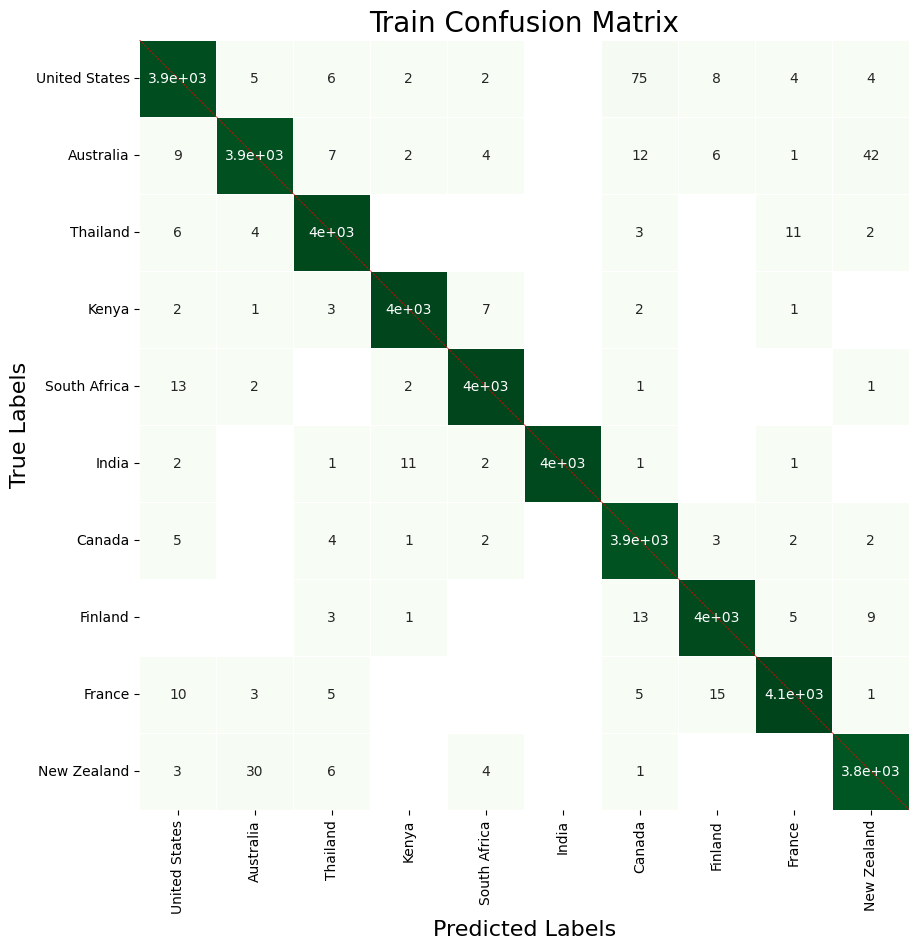

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(10, 10))

# 创建一个布尔掩码，隐藏0值
mask = train_conf_matrix == 0

# 使用深绿色的颜色调色板
sns.heatmap(train_conf_matrix, annot=True, cmap="Greens", cbar=False, 
            linewidths=.5, mask=mask, square=True, 
            xticklabels=country_list, yticklabels=country_list)  # 添加线条分隔，隐藏0值

# 添加斜线标记正确预测的位置
for i in range(min(train_conf_matrix.shape)):  # 仅绘制对角线
    plt.plot([i, i + 1], [i, i + 1], color='red', linewidth=0.5, linestyle='--')

# 添加标题和标签
plt.title("Train Confusion Matrix", fontsize=20)
plt.xlabel("Predicted Labels", fontsize=16)
plt.ylabel("True Labels", fontsize=16)

plt.xlim(0, train_conf_matrix.shape[1])
plt.ylim(train_conf_matrix.shape[0], 0)  # 反转Y轴

# 显示图表
plt.show()

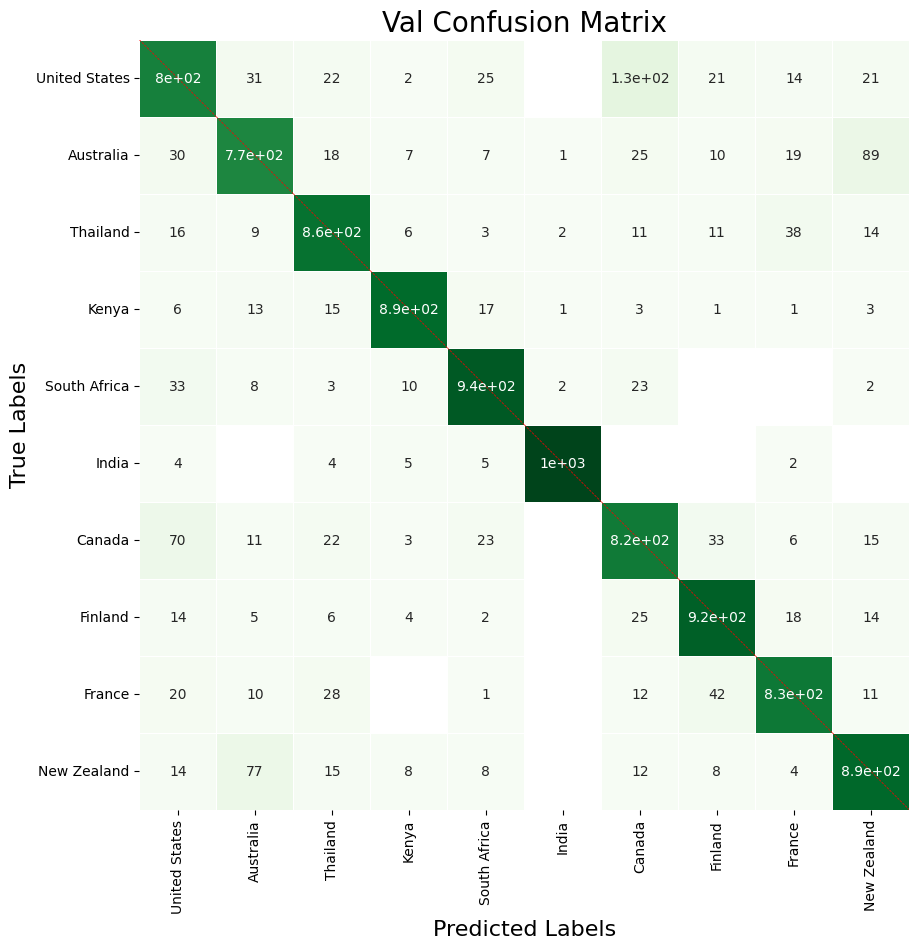

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(10, 10))

# 创建一个布尔掩码，隐藏0值
mask = val_conf_matrix == 0

# 使用深绿色的颜色调色板
sns.heatmap(val_conf_matrix, annot=True, cmap="Greens", cbar=False, 
            linewidths=.5, mask=mask, square=True, 
            xticklabels=country_list, yticklabels=country_list)  # 添加线条分隔，隐藏0值

# 添加斜线标记正确预测的位置
for i in range(min(val_conf_matrix.shape)):  # 仅绘制对角线
    plt.plot([i, i + 1], [i, i + 1], color='red', linewidth=0.5, linestyle='--')

# 添加标题和标签
plt.title("Val Confusion Matrix", fontsize=20)
plt.xlabel("Predicted Labels", fontsize=16)
plt.ylabel("True Labels", fontsize=16)

plt.xlim(0, val_conf_matrix.shape[1])
plt.ylim(val_conf_matrix.shape[0], 0)  # 反转Y轴

# 显示图表
plt.show()

## get f1 score, precision score, recall score

In [21]:
from sklearn.metrics import f1_score, precision_score, recall_score

In [22]:
train_f1 = f1_score(df_train_labels, df_train_predict_outputs.idxmax(axis=1), average='weighted')
train_precision = precision_score(df_train_labels, df_train_predict_outputs.idxmax(axis=1), average='weighted')
train_recall = recall_score(df_train_labels, df_train_predict_outputs.idxmax(axis=1), average='weighted')

In [23]:
print('train sets f1: {}', train_f1)
print('train sets precision: {}', train_precision)
print('train sets recall: {}', train_recall)

train sets f1: {} 0.9899772618648899
train sets precision: {} 0.99002232357024
train sets recall: {} 0.9899765035244713


In [24]:
val_f1 = f1_score(df_val_labels, df_val_predict_outputs.idxmax(axis=1), average='weighted') 
val_precision = precision_score(df_val_labels, df_val_predict_outputs.idxmax(axis=1), average='weighted')
val_recall = recall_score(df_val_labels, df_val_predict_outputs.idxmax(axis=1), average='weighted')

In [25]:
print('val sets f1: {}', val_f1)
print('val sets precision: {}', val_precision)
print('val sets recall: {}', val_recall)

val sets f1: {} 0.8718176316258284
val sets precision: {} 0.8721744584543407
val sets recall: {} 0.8719256148770246


# 計算預測機率

In [26]:
# 計算 Softmax
def softmax(x):
    # 為了穩定性，減去每行的最大值
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

In [27]:
np_val_predict_outputs = df_val_predict_outputs.to_numpy()
np_train_predict_outputs = df_train_predict_outputs.to_numpy()

np_val_predict_softmax_outputs = softmax(np_val_predict_outputs)
np_train_predict_outputs_softmax_outputs = softmax(np_train_predict_outputs)

# 如果你想要將結果放回 DataFrame 中
df_val_predict_outputs_softmax = pd.DataFrame(np_val_predict_softmax_outputs, columns=df_val_predict_outputs.columns)
df_train_predict_outputs_softmax = pd.DataFrame(np_train_predict_outputs_softmax_outputs, columns=df_train_predict_outputs.columns)

In [28]:
val_mean_predictions = np.mean(df_val_predict_outputs_softmax, axis=0)

print(val_mean_predictions.shape)

train_mean_predictions = np.mean(df_train_predict_outputs_softmax, axis=0)

print(train_mean_predictions.shape)

(10,)
(10,)


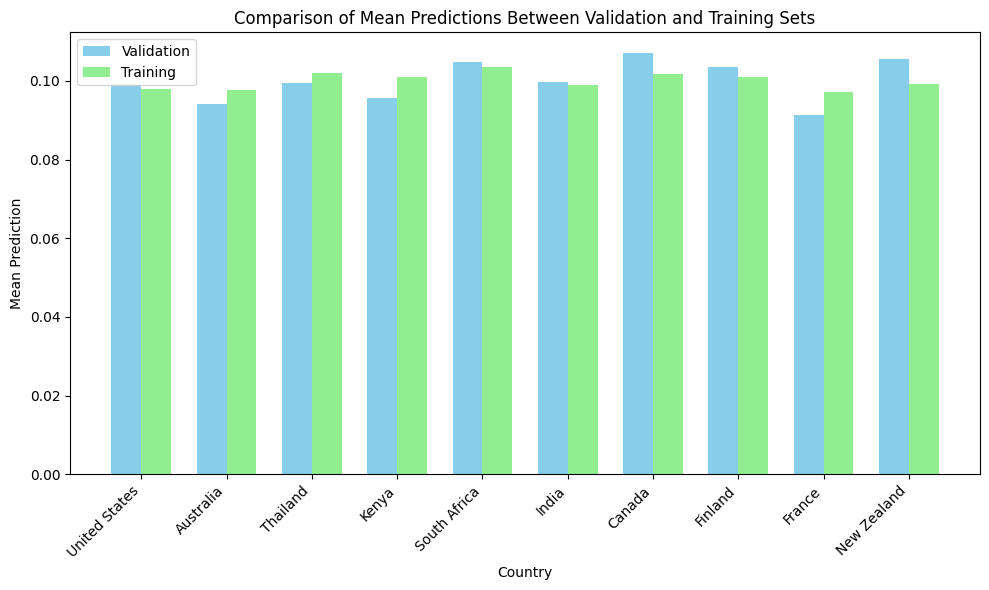

In [29]:
# 設定條形圖的寬度
width = 0.35

# x 軸的座標
x = np.arange(len(country_list))

# 繪製並排的 barplot
plt.figure(figsize=(10, 6))
plt.bar(x - width / 2, val_mean_predictions, width, label='Validation', color='skyblue')
plt.bar(x + width / 2, train_mean_predictions, width, label='Training', color='lightgreen')

# 設置 x 軸的標籤為國家名稱
plt.xticks(x, country_list, rotation=45, ha="right")

# 添加標籤和標題
plt.xlabel('Country')
plt.ylabel('Mean Prediction')
plt.title('Comparison of Mean Predictions Between Validation and Training Sets')
plt.legend()

# 顯示圖形
plt.tight_layout()  # 確保標籤不會重疊
plt.show()

# 顯示圖片

In [30]:
test_output = model.forward(train_dataset[0][0].unsqueeze(0).to(device))
print(pd.DataFrame(test_output.detach().numpy()).idxmax(axis=1))

0    1
dtype: int64


In [31]:
train_dataset.label_df.iloc[0].country

'Australia'

In [32]:
print(train_dataset[0][0].shape)

torch.Size([3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5097837].


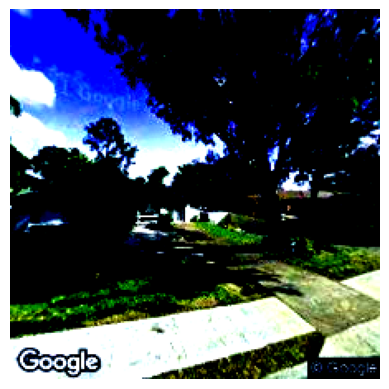

In [33]:
image_tensor = train_dataset[0][0]

# 將圖像張量轉換為 NumPy 陣列 (假設圖像是 3xHxW 格式)
image_np = image_tensor.permute(1, 2, 0).numpy()

# 若圖像範圍在[0, 1]，可以直接顯示；如果在[0, 255]，則需要除以 255
# 假設圖像的數值在 [0, 1] 範圍內
plt.imshow(image_np)
plt.axis('off')  # 隱藏坐標軸
plt.show()

# Heatmap for single image
## Not succeesful, but didnt failed

In [34]:
test_labels = [4]  # 假設你想要測試的標籤

# 將 image_tensor 轉換為 NumPy 格式 (C, H, W) -> (H, W, C)
image = image_tensor.permute(1, 2, 0).cpu().numpy()  # 從 (3, 224, 224) 轉換為 (224, 224, 3)
image_original_uint8 = np.uint8(image * 255)  # 將浮點數圖像轉換為 0~255 的整數範圍

# 產生熱圖
occluding_size = 2
occluding_pixel = 2
occluding_stride = 2

height, width, _ = image.shape

output_height = int(np.ceil((height - occluding_size) / occluding_stride + 1))
output_width = int(np.ceil((width - occluding_size) / occluding_stride + 1))

print(output_height, output_width)
heatmap = np.zeros((output_height, output_width))

for h in range(output_height):
    print(h)
    for w in range(output_width):
        # 遮罩區域
        h_start = h * occluding_stride
        w_start = w * occluding_stride
        h_end = min(height, h_start + occluding_size)
        w_end = min(width, w_start + occluding_size)

        input_image = np.array(image, copy=True)
        input_image[h_start:h_end, w_start:w_end, :] = occluding_pixel  # 對 RGB 進行遮罩

        # 將圖像從 NumPy 陣列轉換回張量並做預測
        input_image_tensor = torch.from_numpy(input_image).permute(2, 0, 1).float() / 255.0  # (H, W, C) -> (C, H, W)
        input_image_tensor = input_image_tensor.unsqueeze(0)  # 增加 batch 維度

        # 預測
        probs = model(input_image_tensor)  # 假設您的模型返回預測結果
        probs = softmax(probs.detach().numpy())
        predicted_prob = probs[0][test_labels[0]]  # 假設您要關注的類別索引是 test_labels[0]

        heatmap[h, w] = predicted_prob.item()  # 提取概率值並存入熱圖
        

112 112
0
1
2
3
4


KeyboardInterrupt: 

In [ ]:
height, width, _ = image.shape
print(height, width)

224 224


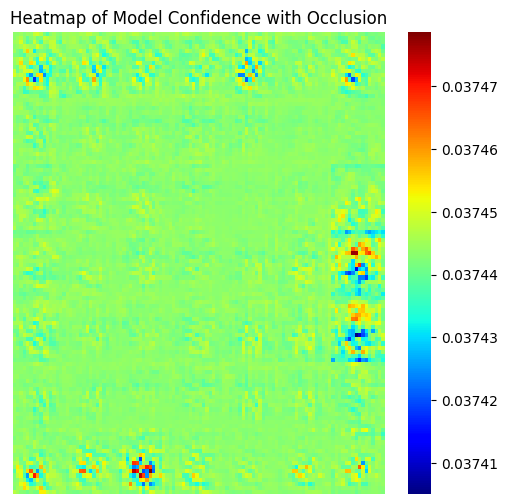

In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(heatmap, xticklabels=False, yticklabels=False, cmap="jet")
plt.title("Heatmap of Model Confidence with Occlusion")
plt.show()

# Saliency Map for getting features of classes 
## (FAILED)

In [35]:
# target_classes = [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12]]
target_classes = [0]
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)

In [36]:
total_epochs = 2000
lr = 1e-6
momentum = 0.2
weight_decay = 0.08
l2_weight = 0.3

In [37]:
'''
row, col = 1, 1
fig, axs = plt.subplots(row, col, figsize=(5 * col, 5 * row))
iter_dir = "testing_saliency_maps"
os.makedirs(iter_dir, exist_ok=True)

imgs = []
for target_class in target_classes:
    img = torch.zeros(size=(3, 3, 224, 224), requires_grad=True)
    optimizer = torch.optim.SGD([img], lr, momentum=momentum, weight_decay=weight_decay)

    for epoch in range(1, total_epochs + 1):
        
        img_before_update = img.clone().detach()
        
        out = model(img)
        score = out[:, target_class] - l2_weight * torch.norm(img)
        
        # Make sure loss is a scalar
        loss = -score.sum()  # or use .sum() if you prefer

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        img_update = img - img_before_update
        if (epoch % 10 == 0):
            print(target_class, epoch, loss.item())
            
            axs[i//col][i%col].imshow(img_update.cpu().detach()[0] + IMAGENET_MEAN)
            axs[i//col][i%col].axis('off')
            plt.show()
            img_0_tensor = transforms.ToTensor()(img)

            # 假設 img_tensor 是未處理的圖像數據（例如 [-1, 1] 或其他範圍）
            img_0_tensor = (img_0_tensor - img_0_tensor.min()) / (img_0_tensor.max() - img_0_tensor.min())
            img_pil = transforms.ToPILImage()(img_0_tensor)
            img_pil.save(f"{iter_dir}/img_{epoch}.png")  # 儲存為 PNG 檔案
            print(f"Saved img_{i}.png")

    img = img.cpu().detach()[0] + IMAGENET_MEAN
    imgs.append(transforms.ToPILImage()(img))
    print()
'''

'\nrow, col = 1, 1\nfig, axs = plt.subplots(row, col, figsize=(5 * col, 5 * row))\niter_dir = "testing_saliency_maps"\nos.makedirs(iter_dir, exist_ok=True)\n\nimgs = []\nfor target_class in target_classes:\n    img = torch.zeros(size=(3, 3, 224, 224), requires_grad=True)\n    optimizer = torch.optim.SGD([img], lr, momentum=momentum, weight_decay=weight_decay)\n\n    for epoch in range(1, total_epochs + 1):\n        \n        img_before_update = img.clone().detach()\n        \n        out = model(img)\n        score = out[:, target_class] - l2_weight * torch.norm(img)\n        \n        # Make sure loss is a scalar\n        loss = -score.sum()  # or use .sum() if you prefer\n\n        optimizer.zero_grad()\n        loss.backward()\n        optimizer.step()\n\n        img_update = img - img_before_update\n        if (epoch % 10 == 0):\n            print(target_class, epoch, loss.item())\n            \n            axs[i//col][i%col].imshow(img_update.cpu().detach()[0] + IMAGENET_MEAN)\n  

KeyboardInterrupt: 

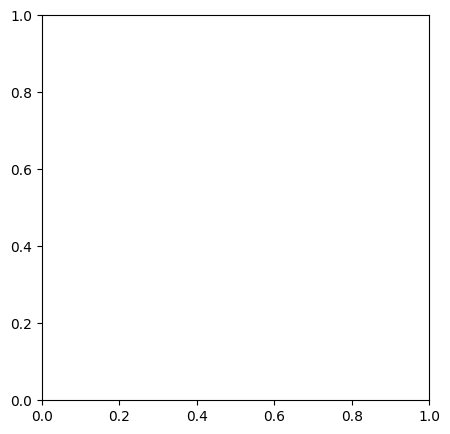

In [38]:
import os
import torch
import matplotlib.pyplot as plt
from torchvision import transforms

row, col = 1, 1
fig, axs = plt.subplots(row, col, figsize=(5 * col, 5 * row))
iter_dir = "testing_saliency_maps"
os.makedirs(iter_dir, exist_ok=True)

plt.ion()

# 如果 axs 是單一個軸物件，將其轉為 list 以便索引
if row == 1 and col == 1:
    axs = [axs]

imgs = []
for i, target_class in enumerate(target_classes):
    img = torch.zeros(size=(3, 3, 224, 224), requires_grad=True)
    optimizer = torch.optim.SGD([img], lr, momentum=momentum, weight_decay=weight_decay)

    for epoch in range(1, total_epochs + 1):
        
        img_before_update = img.clone().detach()
        
        out = model(img)
        score = out[0, :] - l2_weight * torch.norm(img)
        
        # Make sure loss is a scalar
        loss = -score.sum()  # or use .sum() if you prefer

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        img_update = img - img_before_update
        if (epoch % 100 == 0):
            print(target_class, epoch, loss.item(), score)
            
            axs[0].imshow((img_update.cpu().detach()[0] + IMAGENET_MEAN).clamp(0, 1).permute(1, 2, 0))
            axs[0].axis('off')
            
            img_gradient_tensor = img_update.detach().cpu().clone()
            img_gradient_tensor = img_gradient_tensor[0]
            img_gradient_pil = transforms.ToPILImage()(img_gradient_tensor)  # 轉換為 PIL 圖片
            display(img_gradient_pil)
            
            
            img_0_tensor = img.detach().cpu().clone()
            img_0_tensor = img_0_tensor[0]
            img_pil = transforms.ToPILImage()(img_0_tensor)  # 轉換為 PIL 圖片
            img_pil.save(f"{iter_dir}/img_{epoch}.png")
            display(img_pil)
            print(f"Saved img_{epoch}.png")

    img = img.cpu().detach()[0] + IMAGENET_MEAN
    imgs.append(transforms.ToPILImage()(img))
    print()


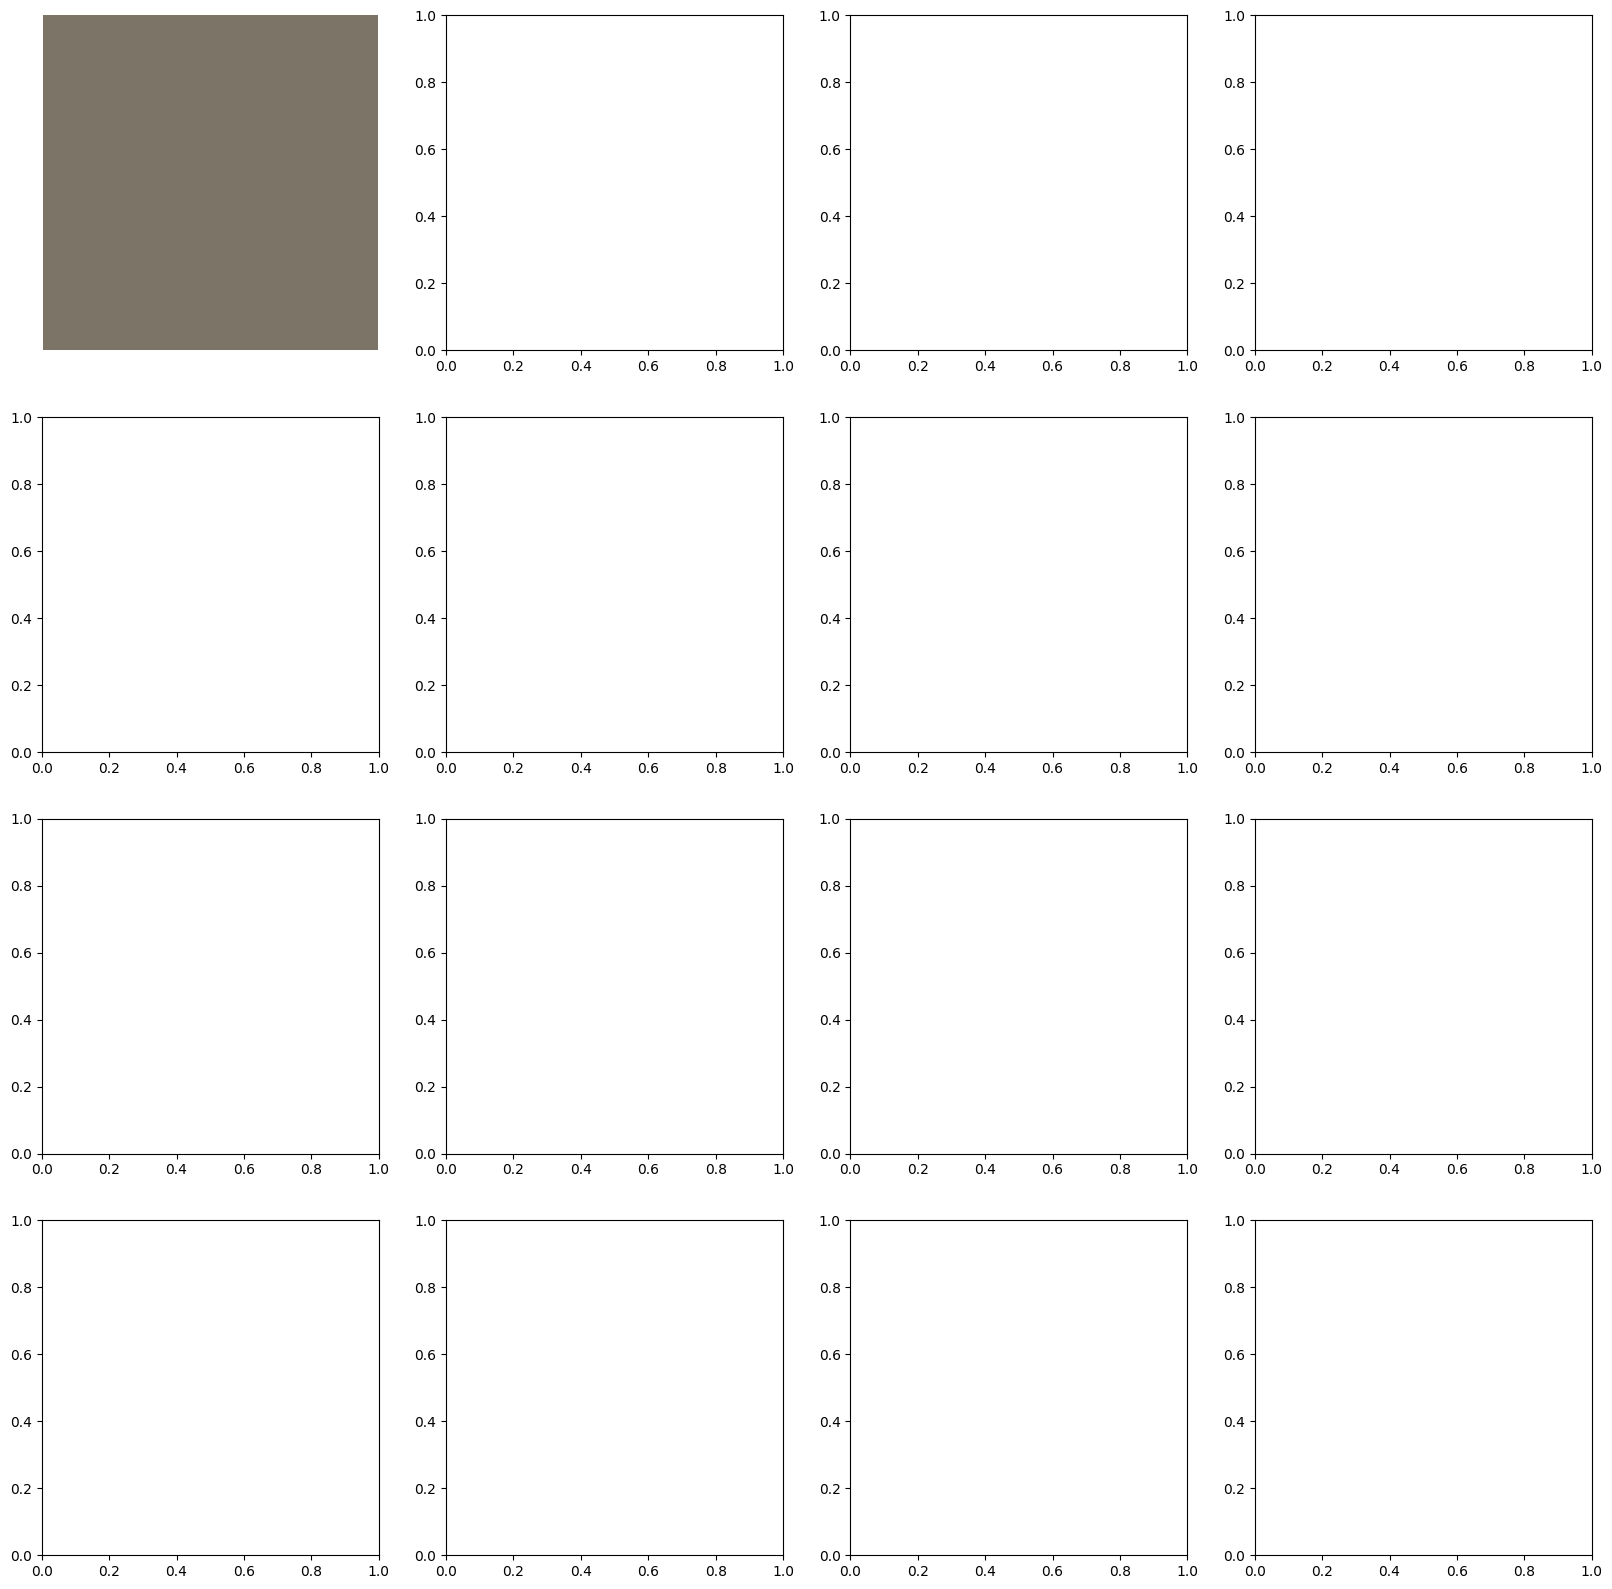

In [ ]:
row, col = 4, 4

fig, axs = plt.subplots(row, col, figsize=(5 * col, 5 * row))

for i, target_class in enumerate(target_classes):
    axs[i//col][i%col].imshow(imgs[i])
    axs[i//col][i%col].axis('off')

plt.show()

In [ ]:
import os

# 建立存檔資料夾
output_dir = "output_images"
os.makedirs(output_dir, exist_ok=True)

for i in range(len(imgs)):
    img_0_tensor = transforms.ToTensor()(imgs[i])

    # 將範圍標準化至 [0, 1]
    img_0_tensor = (img_0_tensor - img_0_tensor.min()) / (img_0_tensor.max() - img_0_tensor.min())
    img_pil = transforms.ToPILImage()(img_0_tensor)

    # 儲存圖片
    img_pil.save(f"{output_dir}/img_{i}.png")  # 儲存為 PNG 檔案
    print(f"Saved img_{i}.png")

'''
# 打印 tensor 的數據
print(img_0_tensor)
print("數據範圍 (min, max):", img_0_tensor.min().item(), img_0_tensor.max().item())
print("尺寸:", img_0_tensor.size())
'''

Saved img_0.png


'\n# 打印 tensor 的數據\nprint(img_0_tensor)\nprint("數據範圍 (min, max):", img_0_tensor.min().item(), img_0_tensor.max().item())\nprint("尺寸:", img_0_tensor.size())\n'

# Salicency map for single image detection

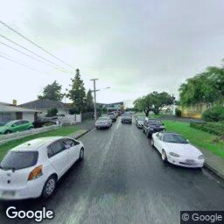

Number of epochs: 1


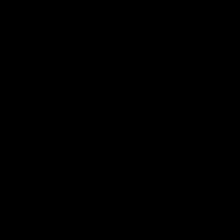

Number of epochs: 2


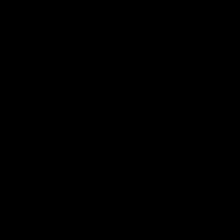

Number of epochs: 3


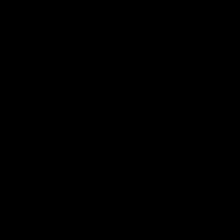

Number of epochs: 4


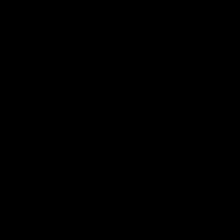

Number of epochs: 5


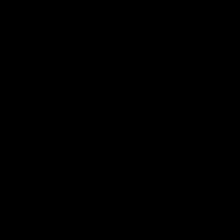

Number of epochs: 6


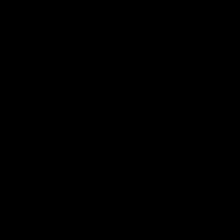

Number of epochs: 7


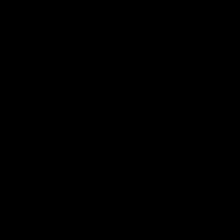

Number of epochs: 8


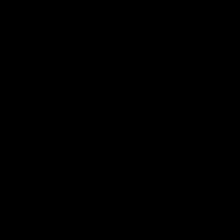

Number of epochs: 9


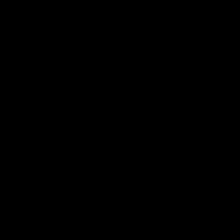

Number of epochs: 10


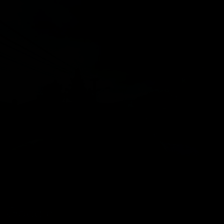

Number of epochs: 11


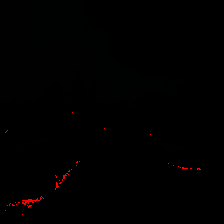

Number of epochs: 12


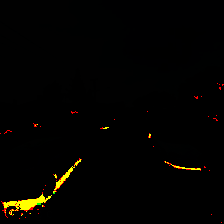

Number of epochs: 13


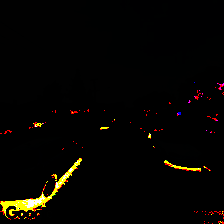

Number of epochs: 14


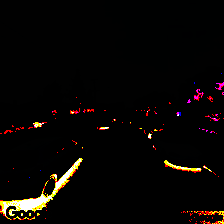

Number of epochs: 15


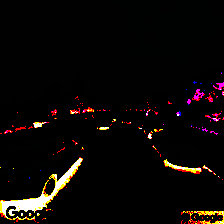

Number of epochs: 16


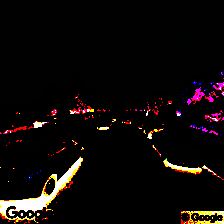

Number of epochs: 17


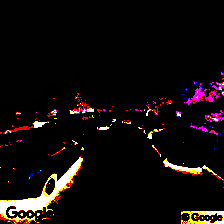

Number of epochs: 18


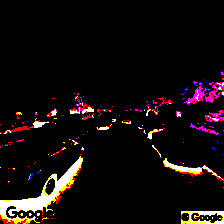

Number of epochs: 19


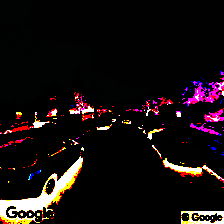

Number of epochs: 20


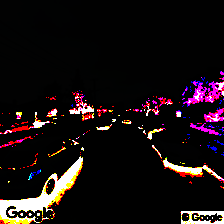

Number of epochs: 21


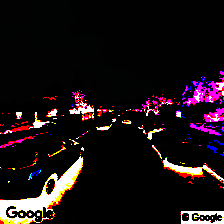

Number of epochs: 22


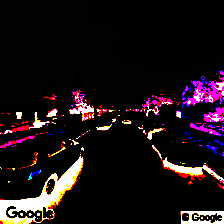

Number of epochs: 23


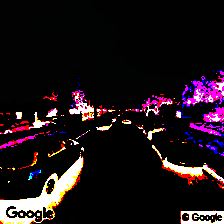

Number of epochs: 24


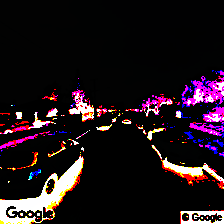

Number of epochs: 25


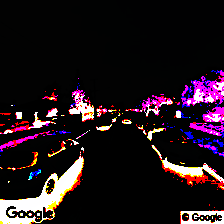

Number of epochs: 26


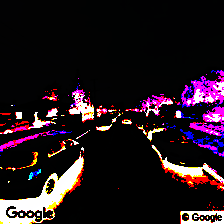

Number of epochs: 27


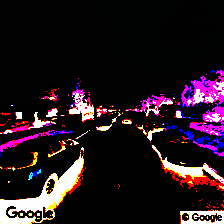

Number of epochs: 28


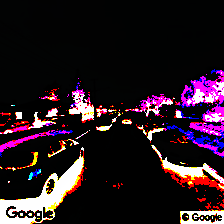

Number of epochs: 29


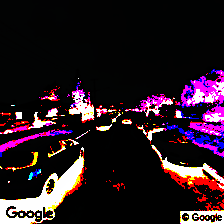

Number of epochs: 30


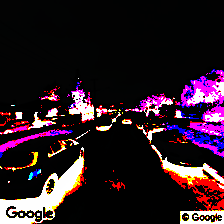

Number of epochs: 31


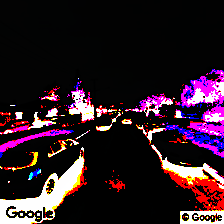

Number of epochs: 32


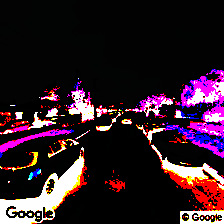

Number of epochs: 33


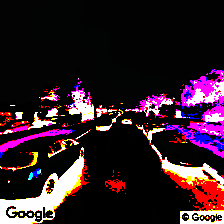

Number of epochs: 34


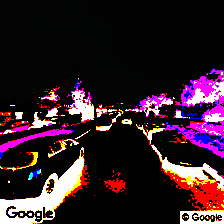

Number of epochs: 35


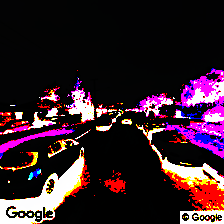

Number of epochs: 36


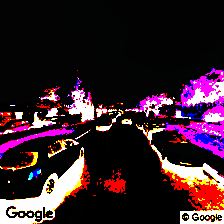

Number of epochs: 37


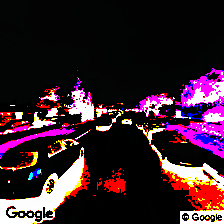

Number of epochs: 38


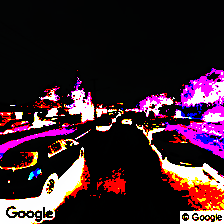

Number of epochs: 39


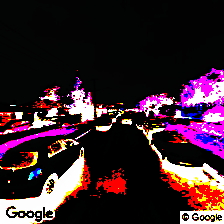

Number of epochs: 40


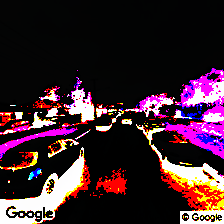

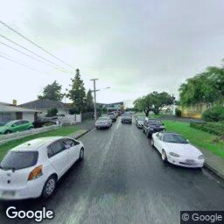

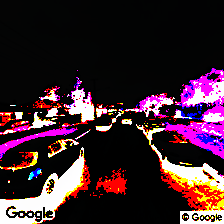

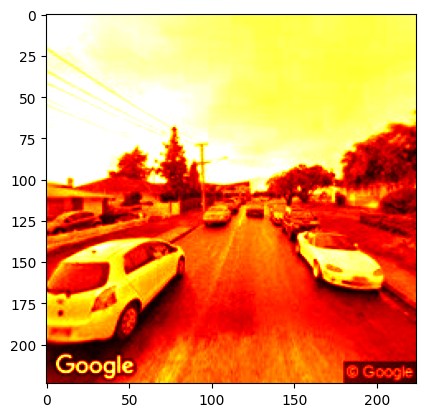

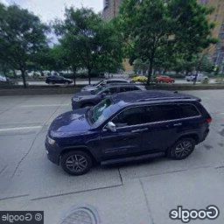

Number of epochs: 1


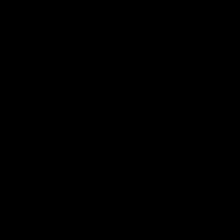

Number of epochs: 2


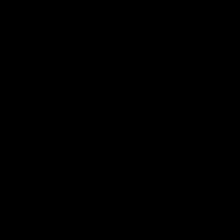

Number of epochs: 3


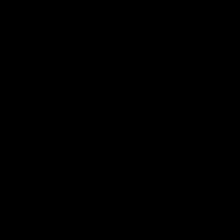

Number of epochs: 4


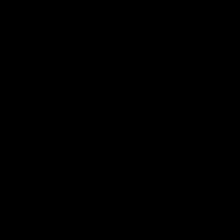

Number of epochs: 5


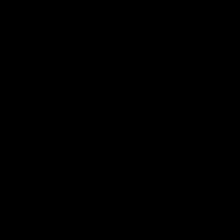

Number of epochs: 6


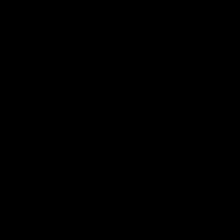

Number of epochs: 7


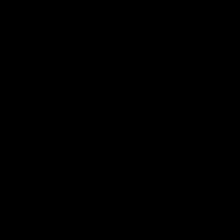

Number of epochs: 8


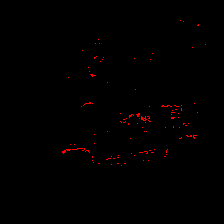

Number of epochs: 9


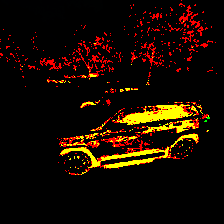

Number of epochs: 10


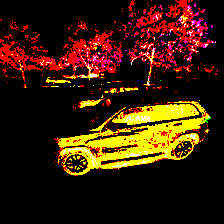

Number of epochs: 11


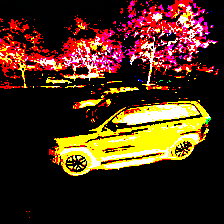

Number of epochs: 12


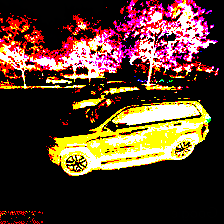

Number of epochs: 13


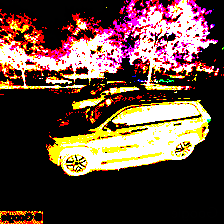

Number of epochs: 14


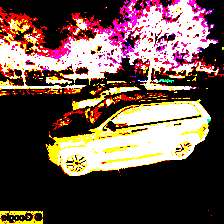

Number of epochs: 15


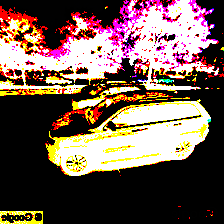

Number of epochs: 16


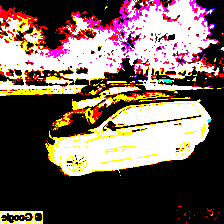

Number of epochs: 17


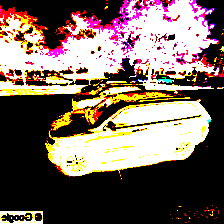

Number of epochs: 18


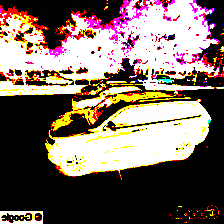

Number of epochs: 19


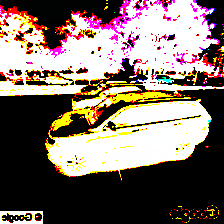

Number of epochs: 20


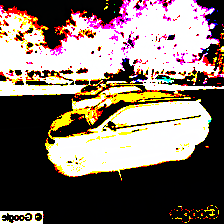

Number of epochs: 21


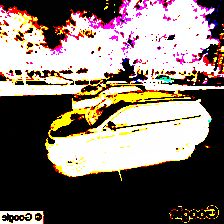

Number of epochs: 22


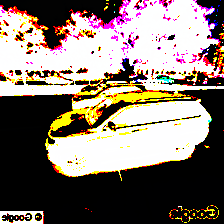

Number of epochs: 23


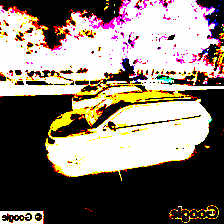

Number of epochs: 24


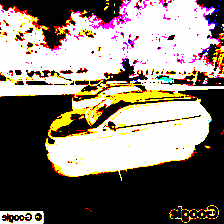

Number of epochs: 25


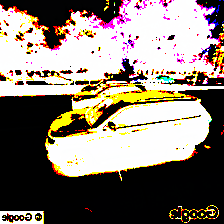

Number of epochs: 26


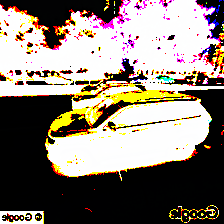

Number of epochs: 27


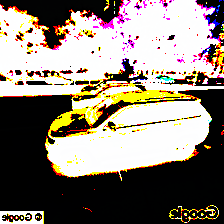

Number of epochs: 28


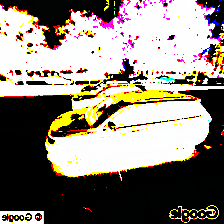

Number of epochs: 29


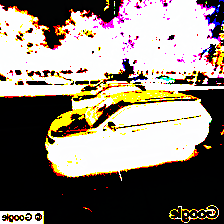

Number of epochs: 30


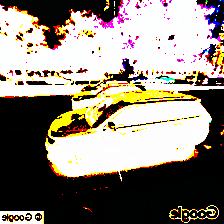

Number of epochs: 31


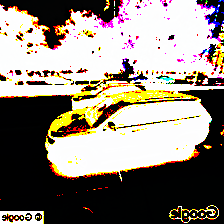

Number of epochs: 32


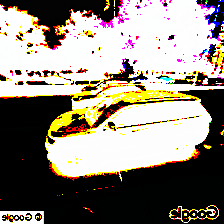

Number of epochs: 33


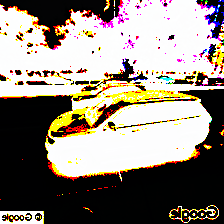

Number of epochs: 34


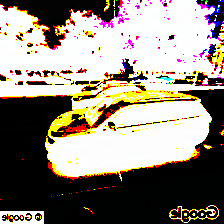

Number of epochs: 35


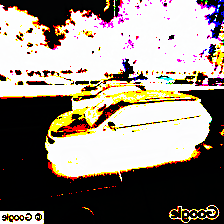

Number of epochs: 36


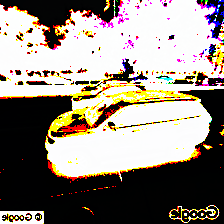

Number of epochs: 37


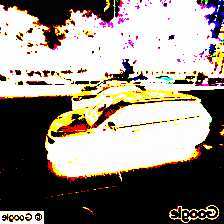

Number of epochs: 38


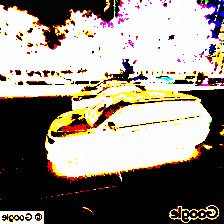

Number of epochs: 39


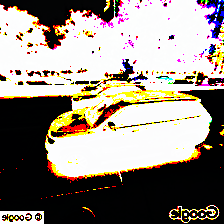

Number of epochs: 40


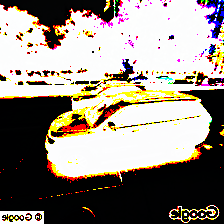

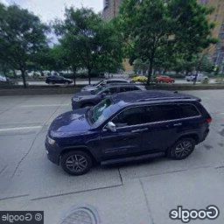

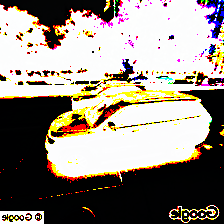

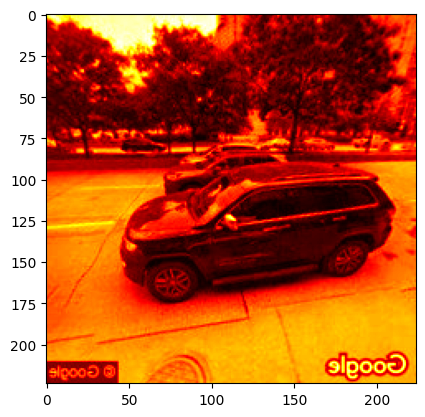

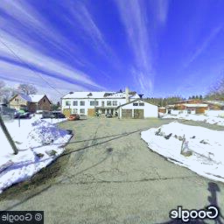

Number of epochs: 1


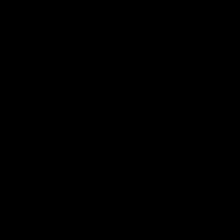

Number of epochs: 2


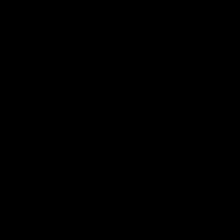

Number of epochs: 3


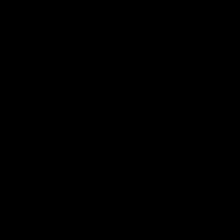

Number of epochs: 4


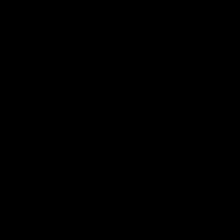

Number of epochs: 5


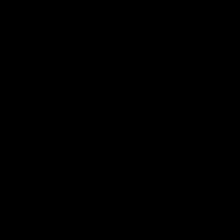

Number of epochs: 6


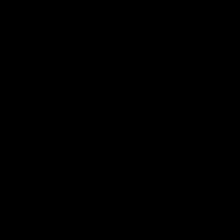

Number of epochs: 7


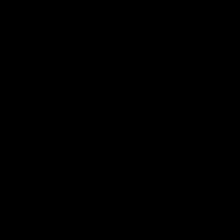

Number of epochs: 8


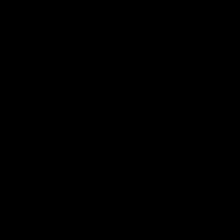

Number of epochs: 9


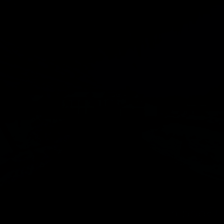

Number of epochs: 10


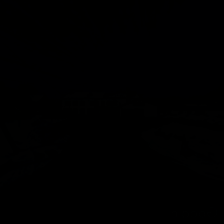

Number of epochs: 11


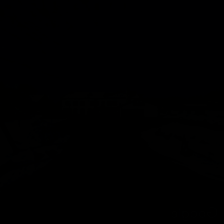

Number of epochs: 12


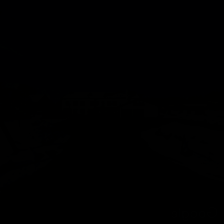

Number of epochs: 13


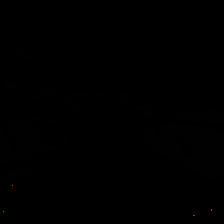

Number of epochs: 14


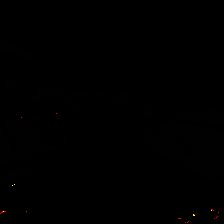

Number of epochs: 15


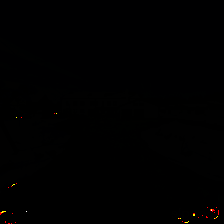

Number of epochs: 16


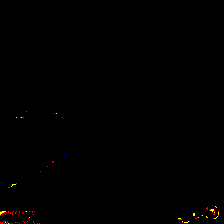

Number of epochs: 17


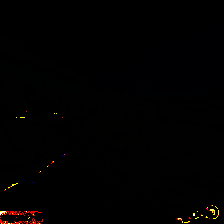

Number of epochs: 18


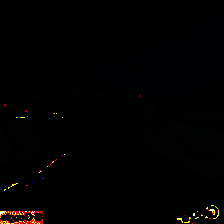

Number of epochs: 19


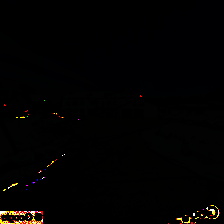

Number of epochs: 20


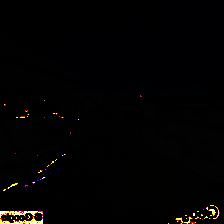

Number of epochs: 21


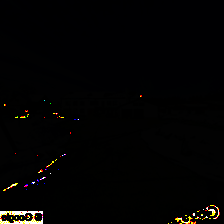

Number of epochs: 22


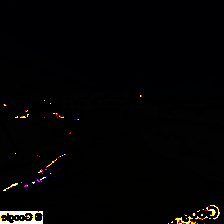

Number of epochs: 23


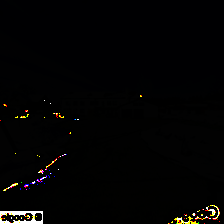

Number of epochs: 24


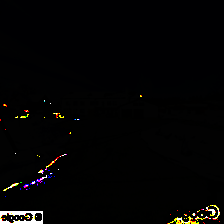

Number of epochs: 25


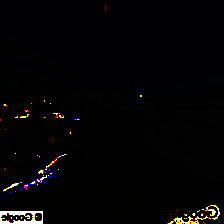

Number of epochs: 26


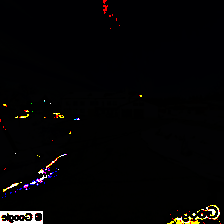

Number of epochs: 27


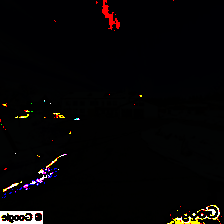

Number of epochs: 28


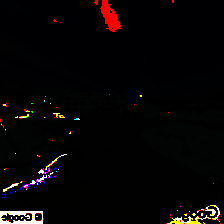

Number of epochs: 29


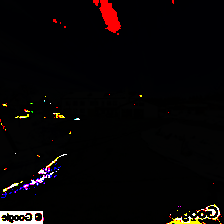

Number of epochs: 30


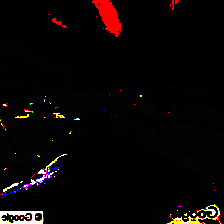

Number of epochs: 31


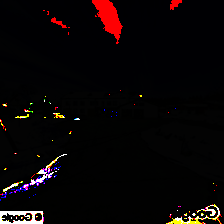

Number of epochs: 32


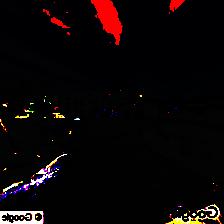

Number of epochs: 33


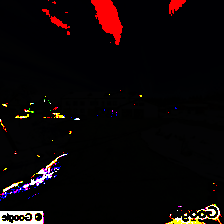

Number of epochs: 34


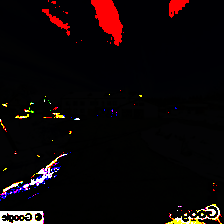

Number of epochs: 35


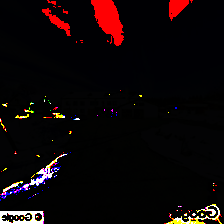

Number of epochs: 36


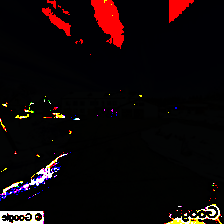

Number of epochs: 37


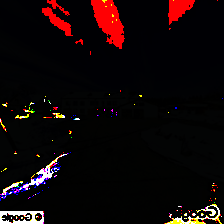

Number of epochs: 38


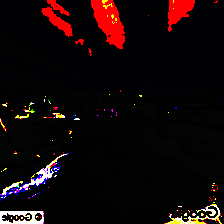

Number of epochs: 39


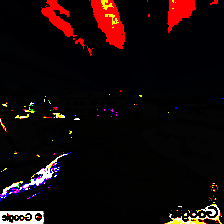

Number of epochs: 40


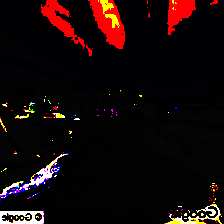

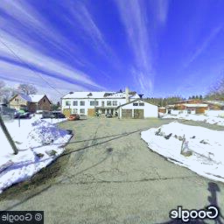

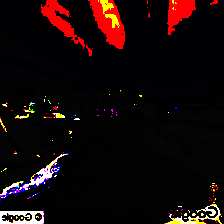

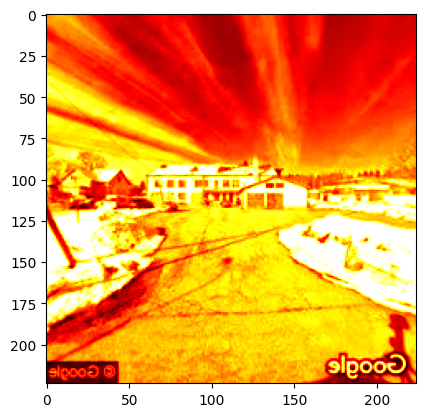

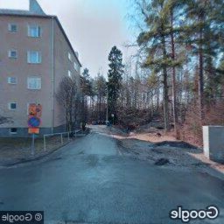

Number of epochs: 1


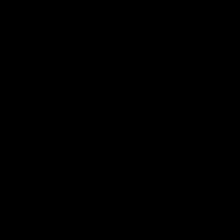

Number of epochs: 2


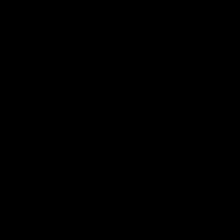

Number of epochs: 3


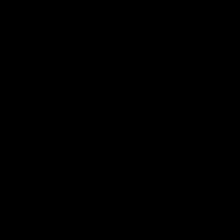

Number of epochs: 4


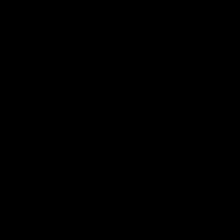

Number of epochs: 5


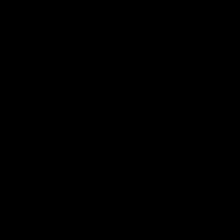

Number of epochs: 6


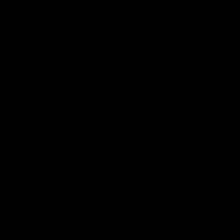

Number of epochs: 7


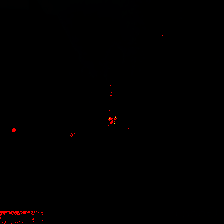

Number of epochs: 8


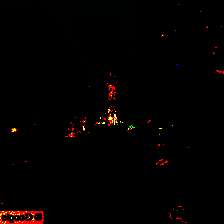

Number of epochs: 9


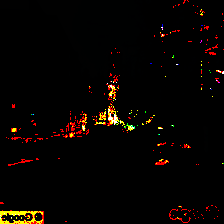

Number of epochs: 10


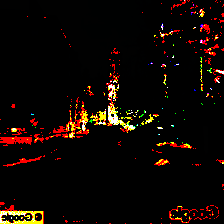

Number of epochs: 11


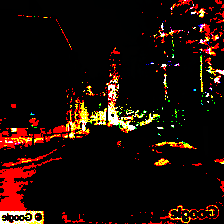

Number of epochs: 12


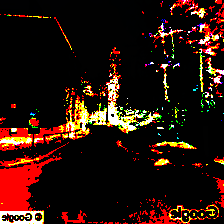

Number of epochs: 13


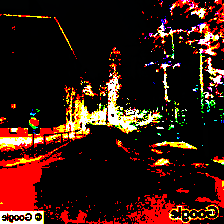

Number of epochs: 14


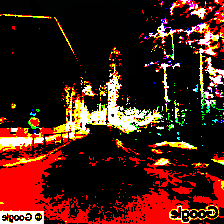

Number of epochs: 15


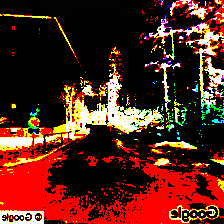

Number of epochs: 16


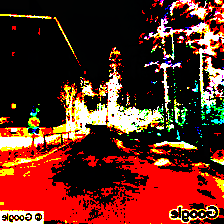

Number of epochs: 17


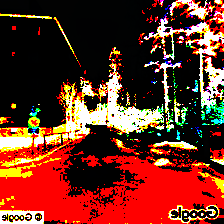

Number of epochs: 18


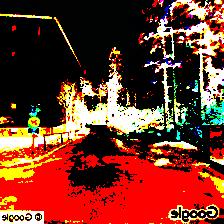

Number of epochs: 19


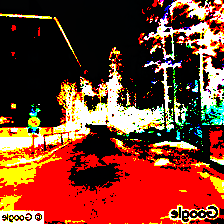

Number of epochs: 20


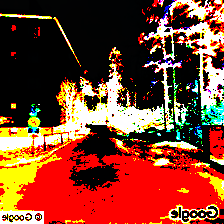

Number of epochs: 21


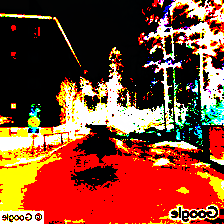

Number of epochs: 22


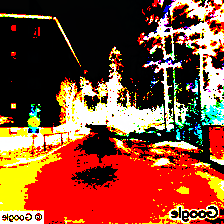

Number of epochs: 23


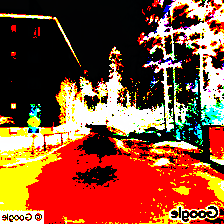

Number of epochs: 24


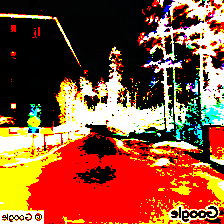

Number of epochs: 25


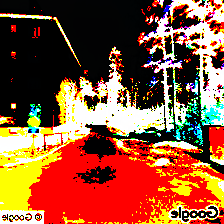

Number of epochs: 26


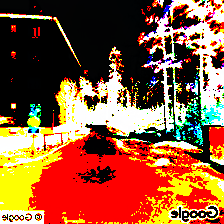

Number of epochs: 27


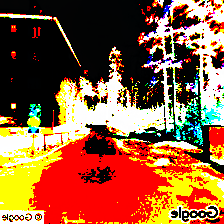

Number of epochs: 28


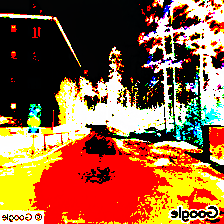

Number of epochs: 29


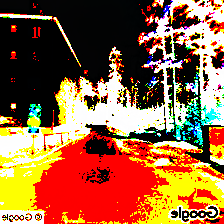

Number of epochs: 30


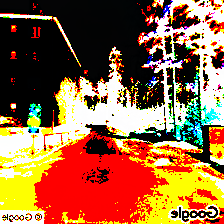

Number of epochs: 31


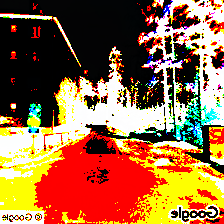

Number of epochs: 32


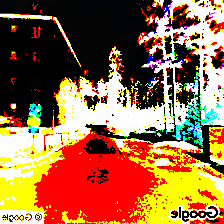

Number of epochs: 33


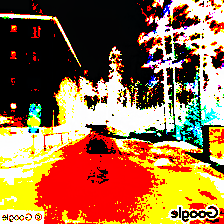

Number of epochs: 34


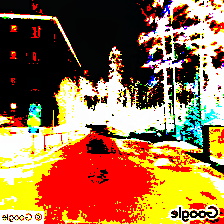

Number of epochs: 35


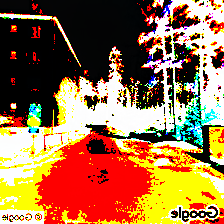

Number of epochs: 36


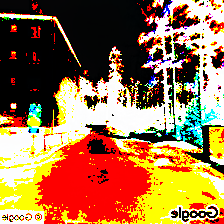

Number of epochs: 37


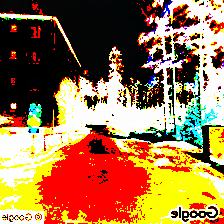

Number of epochs: 38


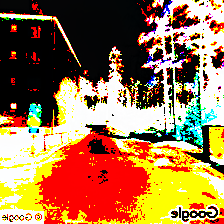

Number of epochs: 39


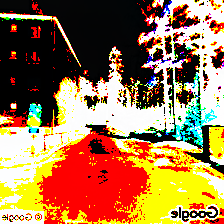

Number of epochs: 40


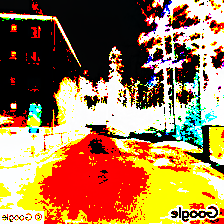

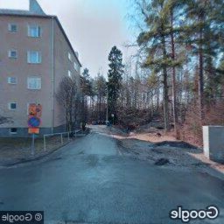

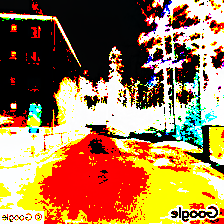

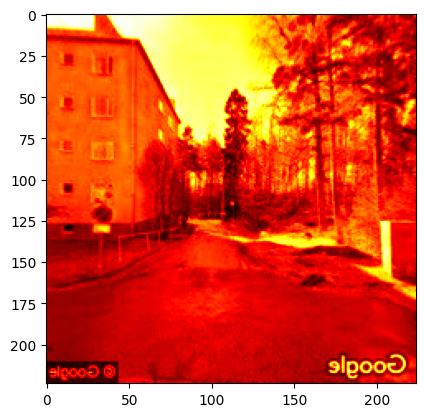

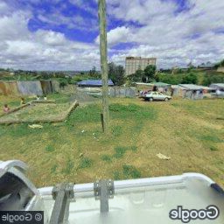

Number of epochs: 1


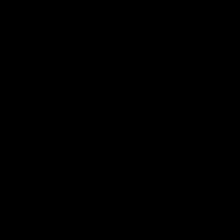

Number of epochs: 2


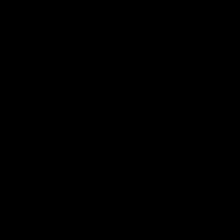

Number of epochs: 3


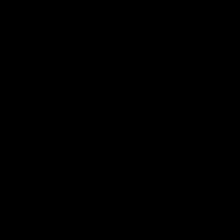

Number of epochs: 4


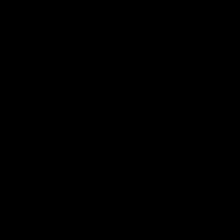

Number of epochs: 5


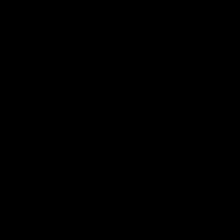

Number of epochs: 6


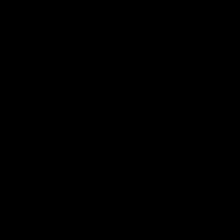

Number of epochs: 7


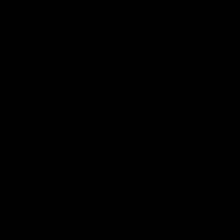

Number of epochs: 8


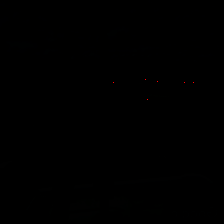

Number of epochs: 9


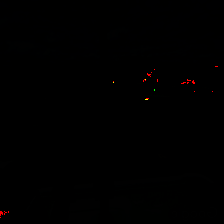

Number of epochs: 10


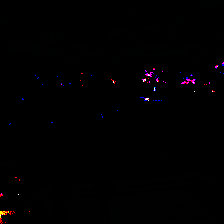

Number of epochs: 11


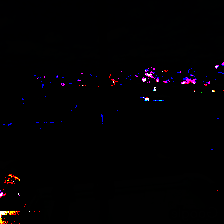

Number of epochs: 12


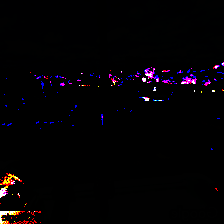

Number of epochs: 13


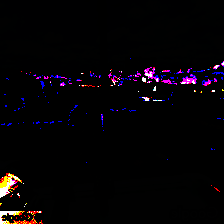

Number of epochs: 14


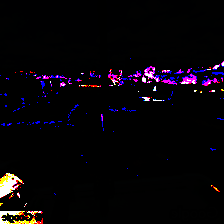

Number of epochs: 15


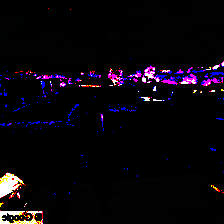

Number of epochs: 16


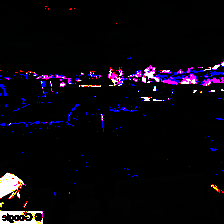

Number of epochs: 17


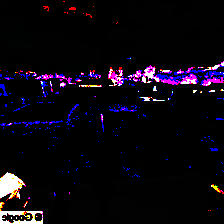

In [ ]:
transform = transforms.Compose([
    # transforms.RandomCrop(80),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

img_change_dir = "training_dataset_results"

images_grad = []

for number in range(1, 20):
    os.makedirs(f"training_dataset_results/{number}", exist_ok=True)
    
    # Assuming `val_dataset` contains only one image and label
    image, label = train_dataset[number]  # Take the first sample (image, label)
    # Move the image and label to the device
    image, label = image.unsqueeze(0).to(device), label.unsqueeze(0).to(device)

    # print(train_dataset[0][0].shape)
    # testing_image_tensor = transform(train_dataset[0][0])

    image_before_update = image.clone().detach()


    # 使 image 可以计算梯度
    image.requires_grad_()

    # 定义优化器，将 image 包含为需要优化的参数
    optimizer = torch.optim.SGD([image], lr=1e-4)  # 示例优化器

    image_before_update = image.clone().detach()

    img_0_tensor = image_before_update.detach().cpu().clone()

    img_0_tensor = img_0_tensor[0]
    img_0_tensor = torch.flip(img_0_tensor, dims=[2])
    img_0_tensor = (img_0_tensor - img_0_tensor.min()) / (img_0_tensor.max() - img_0_tensor.min())

    img_pil = transforms.ToPILImage()(img_0_tensor)
    display(img_pil)

    l2_weight = -100
    for i in range(1, 40 + 1):
        optimizer.zero_grad()  # 清零梯度
        out = model(image)
        score = out[0, :] - l2_weight * torch.norm(image)
        
        # 确保 loss 是标量
        loss = -score.sum()
        loss.backward()  # 计算梯度
        optimizer.step()  # 更新 image
        
        print("Number of epochs: " + str(i))
        # 计算更新后的梯度
        img_update = image - image_before_update
        img_gradient_tensor = img_update.detach().cpu().clone()
        # 转换为 PIL 图像
        img_gradient_tensor = img_gradient_tensor[0]
        img_gradient_tensor = torch.flip(img_gradient_tensor, dims=[2])
        img_gradient_pil = transforms.ToPILImage()(img_gradient_tensor)
        display(img_gradient_pil)
        
        img_gradient_pil.save(f"training_dataset_results/{number}/train_{number}_{i}.png")
            
        # if (i % 2 == 0):
        #     print("Number of epochs: " + str(i))
        #     # 计算更新后的梯度
        #     img_update = image - image_before_update
        #     img_gradient_tensor = img_update.detach().cpu().clone()
        #     # 转换为 PIL 图像
        #     img_gradient_tensor = img_gradient_tensor[0]
        #     img_gradient_tensor = torch.flip(img_gradient_tensor, dims=[2])
        #     img_gradient_pil = transforms.ToPILImage()(img_gradient_tensor)
        #     display(img_gradient_pil)

    img_0_tensor = image_before_update.detach().cpu().clone()

    img_0_tensor = img_0_tensor[0]
    img_0_tensor = torch.flip(img_0_tensor, dims=[2])
    img_0_tensor = (img_0_tensor - img_0_tensor.min()) / (img_0_tensor.max() - img_0_tensor.min())

    img_pil = transforms.ToPILImage()(img_0_tensor)
    display(img_pil)
    img_pil.save(f"{img_change_dir}/train_{number}_original.png")
    
    
    img_gradient_tensor = img_update.detach().cpu().clone()

    img_gradient_tensor = img_gradient_tensor[0]

    # img_gradient_tensor = (img_gradient_tensor - img_gradient_tensor.min()) / (img_gradient_tensor.max() - img_gradient_tensor.min())
    img_gradient_tensor = torch.flip(img_gradient_tensor, dims=[2])
    img_gradient_pil = transforms.ToPILImage()(img_gradient_tensor)  # 轉換為 PIL 圖片
    display(img_gradient_pil)



    # Assuming img_gradient_tensor is of shape (3, 224, 224)
    # Visualize the first channel (index 0)
    plt.imshow((img_gradient_tensor[0]), cmap=plt.cm.hot)  # img_gradient_tensor[0] is (224, 224)
    plt.show()

In [ ]:
transform = transforms.Compose([
    # transforms.RandomCrop(80),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_img_change_dir = "validation_dataset_results"

images_grad = []

for i in range(1, 20):
    os.makedirs(f"validation_dataset_results/{number}", exist_ok=True)
    
    # Assuming `val_dataset` contains only one image and label
    image, label = val_dataset[i]  # Take the first sample (image, label)
    # Move the image and label to the device
    image, label = image.unsqueeze(0).to(device), label.unsqueeze(0).to(device)

    # print(train_dataset[0][0].shape)
    # testing_image_tensor = transform(train_dataset[0][0])

    image_before_update = image.clone().detach()


    # 使 image 可以计算梯度
    image.requires_grad_()

    # 定义优化器，将 image 包含为需要优化的参数
    optimizer = torch.optim.SGD([image], lr=1e-4)  # 示例优化器

    image_before_update = image.clone().detach()

    img_0_tensor = image_before_update.detach().cpu().clone()

    img_0_tensor = img_0_tensor[0]
    img_0_tensor = torch.flip(img_0_tensor, dims=[2])
    img_0_tensor = (img_0_tensor - img_0_tensor.min()) / (img_0_tensor.max() - img_0_tensor.min())

    img_pil = transforms.ToPILImage()(img_0_tensor)
    display(img_pil)

    l2_weight = -100
    for i in range(1, 40 + 1):
        optimizer.zero_grad()  # 清零梯度
        out = model(image)
        score = out[0, :] - l2_weight * torch.norm(image)
        
        # 确保 loss 是标量
        loss = -score.sum()
        loss.backward()  # 计算梯度
        optimizer.step()  # 更新 image
        
        print("Number of epochs: " + str(i))
        # 计算更新后的梯度
        img_update = image - image_before_update
        img_gradient_tensor = img_update.detach().cpu().clone()
        # 转换为 PIL 图像
        img_gradient_tensor = img_gradient_tensor[0]
        img_gradient_tensor = torch.flip(img_gradient_tensor, dims=[2])
        img_gradient_pil = transforms.ToPILImage()(img_gradient_tensor)
        display(img_gradient_pil)
        
        img_gradient_pil.save(f"validation_dataset_results/{number}/train_{number}_{i}.png")
        # if (i % 2 == 0):
        #     print("Number of epochs: " + str(i))
        #     # 计算更新后的梯度
        #     img_update = image - image_before_update
        #     img_gradient_tensor = img_update.detach().cpu().clone()
        #     # 转换为 PIL 图像
        #     img_gradient_tensor = img_gradient_tensor[0]
        #     img_gradient_tensor = torch.flip(img_gradient_tensor, dims=[2])
        #     img_gradient_pil = transforms.ToPILImage()(img_gradient_tensor)
        #     display(img_gradient_pil)

    img_0_tensor = image_before_update.detach().cpu().clone()

    img_0_tensor = img_0_tensor[0]
    img_0_tensor = torch.flip(img_0_tensor, dims=[2])
    img_0_tensor = (img_0_tensor - img_0_tensor.min()) / (img_0_tensor.max() - img_0_tensor.min())

    img_pil = transforms.ToPILImage()(img_0_tensor)
    display(img_pil)
    img_pil.save(f"{test_img_change_dir}/vaildation_{number}_original.png")
    
    img_gradient_tensor = img_update.detach().cpu().clone()

    img_gradient_tensor = img_gradient_tensor[0]

    # img_gradient_tensor = (img_gradient_tensor - img_gradient_tensor.min()) / (img_gradient_tensor.max() - img_gradient_tensor.min())
    img_gradient_tensor = torch.flip(img_gradient_tensor, dims=[2])
    img_gradient_pil = transforms.ToPILImage()(img_gradient_tensor)  # 轉換為 PIL 圖片
    display(img_gradient_pil)



    # Assuming img_gradient_tensor is of shape (3, 224, 224)
    # Visualize the first channel (index 0)
    plt.imshow((img_gradient_tensor[0]), cmap=plt.cm.hot)  # img_gradient_tensor[0] is (224, 224)
    plt.show()

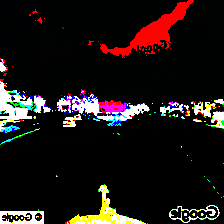

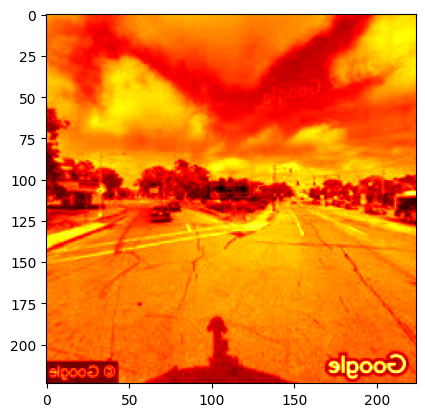

In [ ]:

img_gradient_tensor = img_update.detach().cpu().clone()

img_gradient_tensor = img_gradient_tensor[0]

# img_gradient_tensor = (img_gradient_tensor - img_gradient_tensor.min()) / (img_gradient_tensor.max() - img_gradient_tensor.min())
img_gradient_tensor = torch.flip(img_gradient_tensor, dims=[2])
img_gradient_pil = transforms.ToPILImage()(img_gradient_tensor)  # 轉換為 PIL 圖片
display(img_gradient_pil)



# Assuming img_gradient_tensor is of shape (3, 224, 224)
# Visualize the first channel (index 0)
plt.imshow((img_gradient_tensor[0]), cmap=plt.cm.hot)  # img_gradient_tensor[0] is (224, 224)
plt.show()

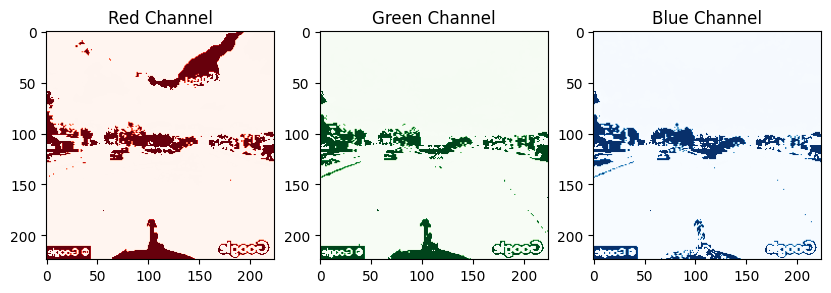

In [ ]:
img_gradient_tensor = img_update.detach().cpu().clone()

img_gradient_tensor = img_gradient_tensor[0]

img_gradient_tensor = torch.flip(img_gradient_tensor, dims=[2])
r, g, b = img_gradient_tensor[0, :, :], img_gradient_tensor[1, :, :], img_gradient_tensor[2, :, :]

# 將通道轉換為 2D tensor 以便顯示
r = r.unsqueeze(0)  # 增加一個維度，變為 (1, 224, 224)
g = g.unsqueeze(0)
b = b.unsqueeze(0)

# 創建 3 個通道的灰階圖像
r_image = transforms.ToPILImage()(r.squeeze(0))
g_image = transforms.ToPILImage()(g.squeeze(0))
b_image = transforms.ToPILImage()(b.squeeze(0))

# 顯示每個通道
plt.figure(figsize=(10, 3))

plt.subplot(1, 3, 1)
plt.imshow(r_image, cmap='Reds')
plt.title('Red Channel')

plt.subplot(1, 3, 2)
plt.imshow(g_image, cmap='Greens')
plt.title('Green Channel')

plt.subplot(1, 3, 3)
plt.imshow(b_image, cmap='Blues')
plt.title('Blue Channel')

plt.show()

# CAM
## Failed

In [616]:
def grad_cam(model, image, target_class, target_layer):
    # Perform forward pass
    model.eval()
    output = model(image)
    
    # Zero the gradients
    model.zero_grad()

    # Backpropagate to get gradients of target class
    target = output[0][target_class]  # Select the score of the target class
    target.backward()

    # Get the feature maps and gradients
    feature_maps = features[0]  # The first (and only) layer's output
    gradients = gradients[0]

    # Compute the weights
    weights = torch.mean(gradients, dim=(2, 3), keepdim=True)

    # Weight the feature maps
    weighted_feature_maps = weights * feature_maps

    # Sum over the channels
    cam = torch.sum(weighted_feature_maps, dim=1).squeeze()

    # Apply ReLU (to focus on positive importance)
    cam = F.relu(cam)

    # Upsample the CAM to match the input image size
    cam = cam.unsqueeze(0)  # Add batch dimension
    cam = F.interpolate(cam, size=(image.shape[2], image.shape[3]), mode='bilinear', align_corners=False)

    # Normalize the CAM for visualization
    cam = cam - torch.min(cam)
    cam = cam / torch.max(cam)

    return cam.squeeze().cpu().detach().numpy()

In [619]:
import cv2
def visualize_grad_cam(cam, original_image):
    # Convert CAM to a heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)

    # Convert original image to numpy
    original_image = original_image.squeeze().cpu().detach().numpy().transpose(1, 2, 0)
    original_image = np.uint8(255 * original_image)

    # Superimpose the heatmap onto the original image
    overlay = cv2.addWeighted(original_image, 0.5, heatmap, 0.5, 0)

    return Image.fromarray(overlay)

In [ ]:
def register_hooks(model, target_layer):
    # List to store feature maps and gradients
    features = []
    gradients = []

    def save_features(module, input, output):
        features.append(output)

    def save_gradients(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    # Register hooks for feature map and gradients
    target_layer.register_forward_hook(save_features)
    target_layer.register_backward_hook(save_gradients)

    return features, gradients

In [634]:
target_layer = model.class_head  # Example: for ResNet, this might be the last convolution layer
features, gradients = register_hooks(model, target_layer)

KeyError: Linear(in_features=1000, out_features=13, bias=True)

In [632]:
print(target_layer)

Linear(in_features=1000, out_features=13, bias=True)


In [628]:
image, label = train_dataset[0]  # Take the first sample (image, label)

# Class index (e.g., 0 for the first class)
target_class = 0


# Move the image and label to the device
image, label = image.unsqueeze(0).to(device), label.unsqueeze(0).to(device)

print(image.shape)
# Compute Grad-CAM
cam = grad_cam(model, image, target_class, target_layer)

# Visualize Grad-CAM
visualized_image = visualize_grad_cam(cam, image_tensor)
display(visualized_image)

torch.Size([1, 3, 224, 224])


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


UnboundLocalError: local variable 'gradients' referenced before assignment